In [154]:
import time
import inspect
import warnings
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [136]:
def wrangle(filepath,resample_rule="1H"):
    df = pd.read_csv(filepath,sep=';', encoding='latin-1')
    df["timestamp"]=df["timestamp"].str.replace("|" ," ")
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index("timestamp", inplace=True)
    # Localize timezone
    
    df.index=df.index.tz_localize('UTC').tz_convert('Africa/Dar_es_Salaam')
    # remove outliers
    df=df[df['P2']< 100]
    # Resample and forward-fill
    y = df["P2"].resample(resample_rule).mean().fillna(method="ffill")
    return y

In [137]:
y = wrangle("data/Dar es Salaam-air-quality.csv")
y.head()

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\3289462976.py:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



timestamp
2018-01-01 03:00:00+03:00    9.456327
2018-01-01 04:00:00+03:00    9.400833
2018-01-01 05:00:00+03:00    9.331458
2018-01-01 06:00:00+03:00    9.528776
2018-01-01 07:00:00+03:00    8.861250
Freq: H, Name: P2, dtype: float64

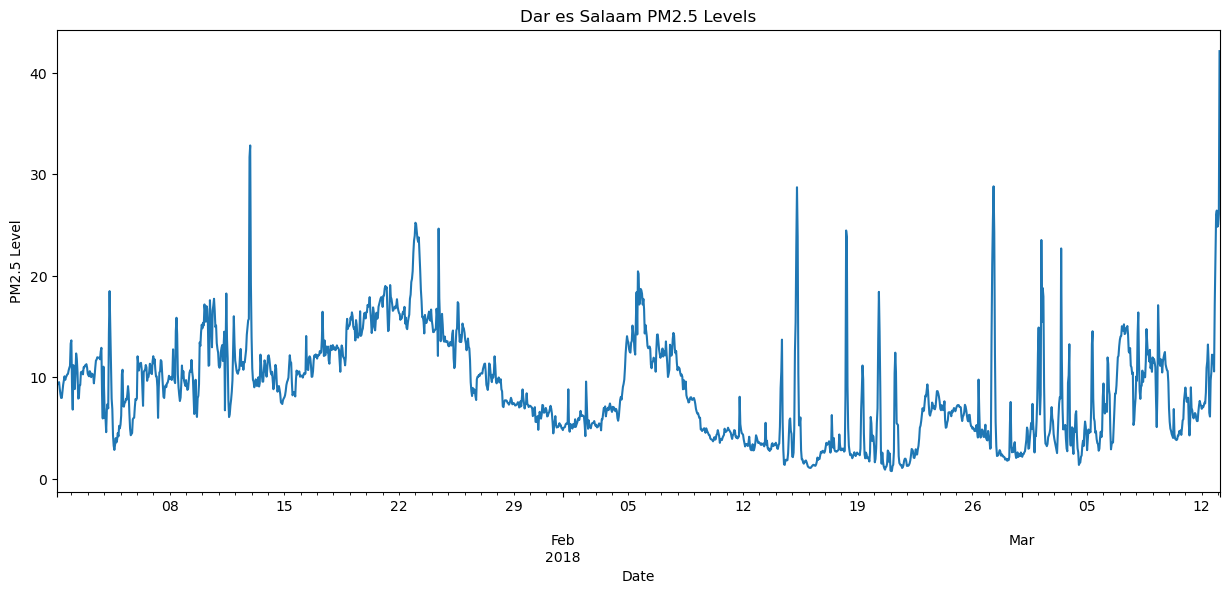

In [139]:
# Explore
fig, ax = plt.subplots(figsize=(15, 6))
y.plot(xlabel="Date",ylabel="PM2.5 Level",title='Dar es Salaam PM2.5 Levels',ax=ax);

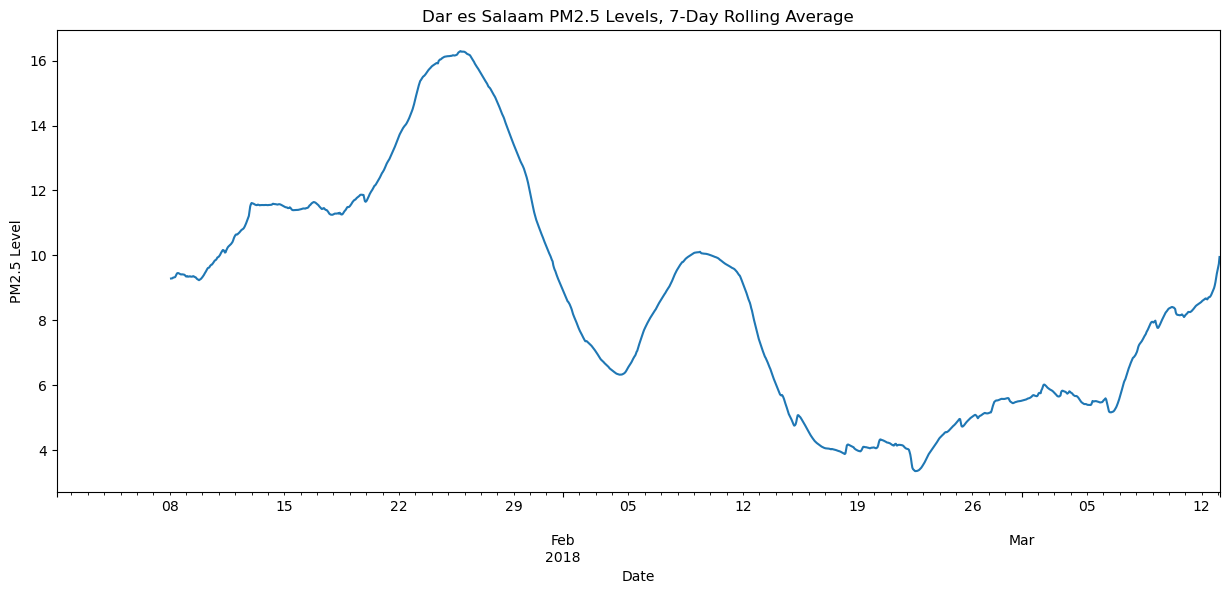

In [141]:
# Plot for the rolling average of the readings in y
fig, ax = plt.subplots(figsize=(15, 6))
y.rolling(168).mean().plot(xlabel="Date",
                                  ylabel="PM2.5 Level",
                                  title='Dar es Salaam PM2.5 Levels, 7-Day Rolling Average',
                                  ax=ax);

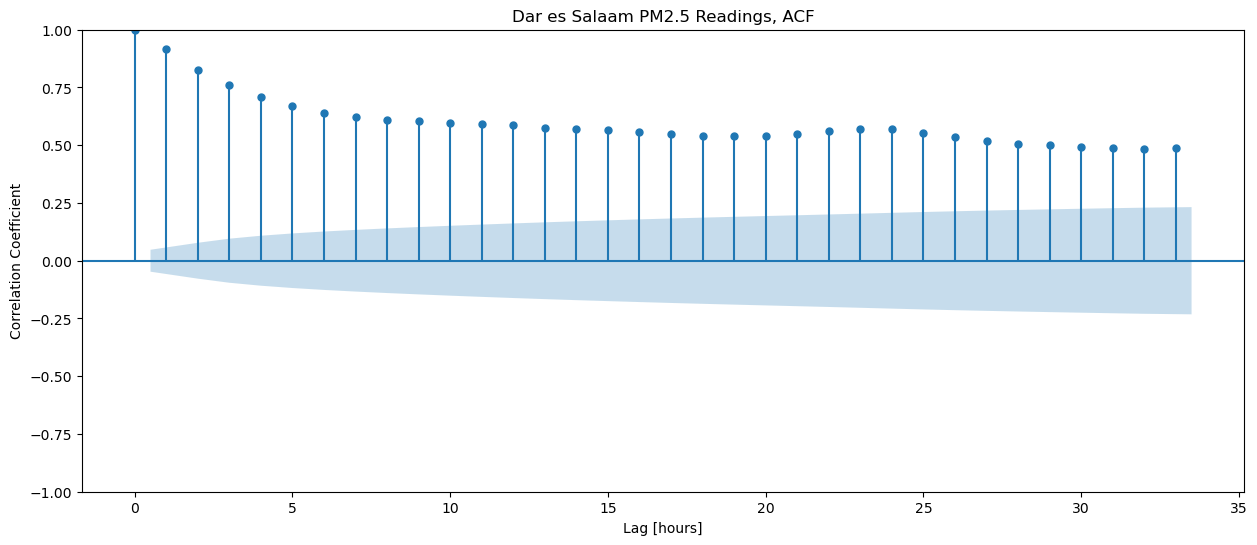

In [142]:
# ACF plot for the data
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title ("Dar es Salaam PM2.5 Readings, ACF");

C:\Users\PanDa\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



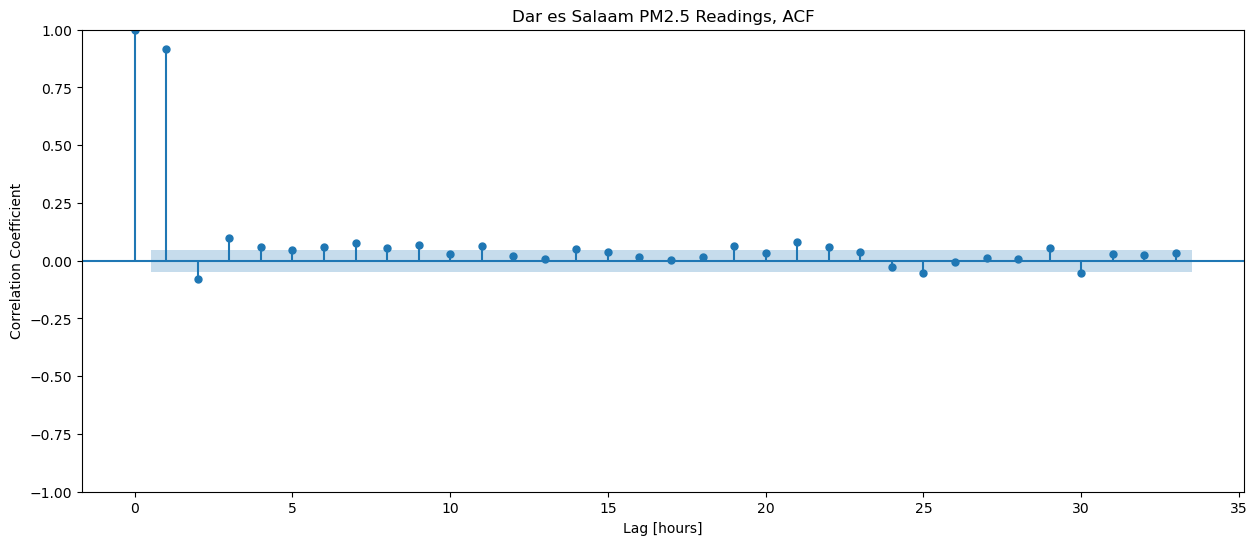

In [143]:
# PACF plot for the data
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title ("Dar es Salaam PM2.5 Readings, ACF");

In [144]:
# Split
cutoff_test = int(len(y)*0.9)
y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1533,)
y_test shape: (171,)


In [145]:
# Build Model
# Baseline
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean]*len(y_train)
mae_baseline =mean_absolute_error(y_train,y_pred_baseline)
print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P2 Reading: 8.617582545265428
Baseline MAE: 4.07658759405218


In [146]:
# Iterate
p_params = range(1,31)
maes = []
for p in p_params:
    model=AutoReg(y_train,lags=p).fit()
    y_pred = model.predict()
    maes.append(mean_absolute_error(y_train[p:],y_pred[p:]))
    
mae_series = pd.Series(maes, name="mae", index=p_params)
mae_series.head()

1    0.947888
2    0.933894
3    0.920850
4    0.920153
5    0.919519
Name: mae, dtype: float64

In [147]:
# the best p for the best model
best_p =mae_series.idxmin(mae_series.min())
best_model = AutoReg(y_train,lags=best_p).fit()

In [148]:
# the training residuals for best_model
y_train_resid = best_model.resid
y_train_resid.name = "residuals"
y_train_resid.head()

timestamp
2018-01-02 07:00:00+03:00    1.732488
2018-01-02 08:00:00+03:00   -0.381568
2018-01-02 09:00:00+03:00   -0.560971
2018-01-02 10:00:00+03:00   -2.215760
2018-01-02 11:00:00+03:00    0.006468
Freq: H, Name: residuals, dtype: float64

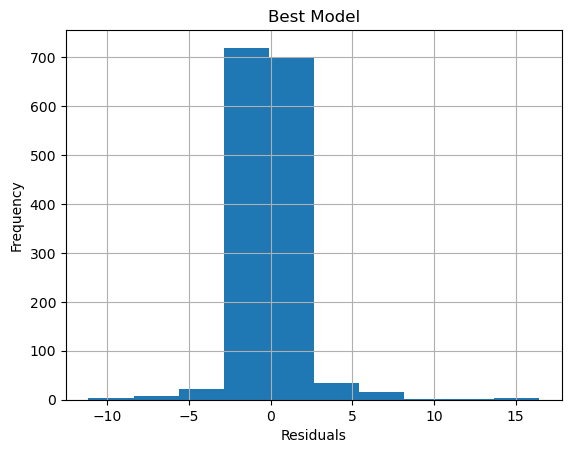

In [149]:
# histogram of residuals
y_train_resid.hist()
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Best Model");

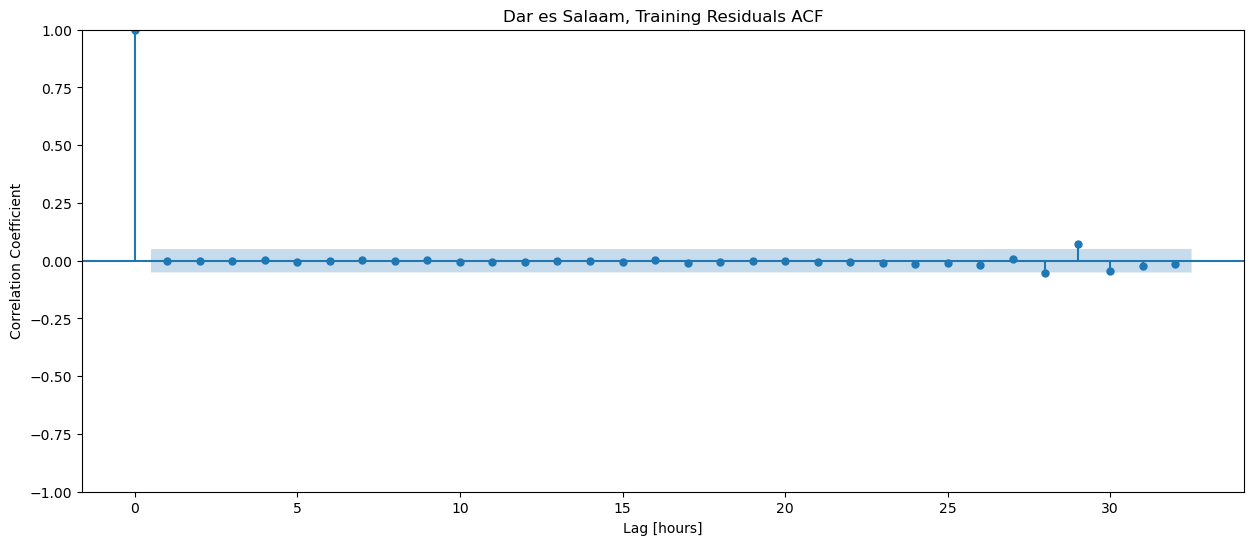

In [150]:
# ACF plot for y_train_resid
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title ("Dar es Salaam, Training Residuals ACF");

In [151]:
# Evaluate
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model=AutoReg(history,lags=best_p).fit()
    next_predict=model.forecast()
    y_pred_wfv=y_pred_wfv.append(next_predict)
    history = history.append(y_test[next_predict.index])
y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:2: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future 

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PanDa\AppData\Local\Temp\ipykernel_12836\993537219.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

timestamp
2018-03-06 00:00:00+03:00    8.056391
2018-03-06 01:00:00+03:00    8.681779
2018-03-06 02:00:00+03:00    6.268951
2018-03-06 03:00:00+03:00    6.303760
2018-03-06 04:00:00+03:00    7.171444
Freq: H, Name: prediction, dtype: float64

In [157]:
# Communicate Results
df_pred_test = pd.DataFrame({"y_test":y_test,"y_pred_wfv":y_pred_wfv})
fig =  px.line(df_pred_test,labels={"value":"PM2.5"})
fig.update_layout(
    title="Dar es Salaam, WFV Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
)
fig.show();